In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

number_of_rounds = 10

# Function to clean and extract numbers based on formatting
def clean_column_values(value):
    # Check if value is NaN or already a float
    if pd.isna(value):
        return np.nan
    elif isinstance(value, (int, float)):
        return value
    try:
        # If the value contains "of", extract the first number
        if " of " in value:
            return int(value.split(' of ')[0])
        # If the value ends with "%", extract the number and convert to decimal
        elif "%" in value:
            return float(value.strip('%')) / 100
        # Otherwise, try to convert the value to float directly
        else:
            return float(value)
    except (ValueError, AttributeError):
        # Handle unexpected formats by returning None
        return np.nan

# Load the dataset
df = pd.read_csv('ufc_fight_stats.csv')  # Adjust the file path if necessary

# Apply cleaning function to relevant columns
columns_to_clean = ['SIG.STR.', 'SIG.STR. %', 'TOTAL STR.', 'TD', 'TD %', 'CTRL', 'HEAD', 'BODY', 'LEG', 'DISTANCE', 'CLINCH', 'GROUND']
for col in columns_to_clean:
    df[col] = df[col].apply(clean_column_values)

# Proceed with data preparation
def prepare_data(df, n_rounds=number_of_rounds, columns_to_include=['SIG.STR.']):
    rows = []
    
    fighters = df['FIGHTER'].unique()
    
    for fighter in fighters:
        fighter_data = df[df['FIGHTER'] == fighter]
        rounds = fighter_data['ROUND'].unique()
        
        for round_num in rounds:
            current_round_data = fighter_data[fighter_data['ROUND'] == round_num]
            
            if len(current_round_data) == 0:
                continue
            
            past_fighter_data = fighter_data[fighter_data['ROUND'] < round_num].tail(n_rounds)
            
            if len(past_fighter_data) < n_rounds:
                continue

            opponent_data = df[df['FIGHTER'] != fighter]
            opponent_data = opponent_data[opponent_data['ROUND'] == round_num]
            
            if len(opponent_data) == 0:
                continue
            
            opponent_fighter = opponent_data['FIGHTER'].values[0]
            past_opponent_data = df[df['FIGHTER'] == opponent_fighter]
            past_opponent_data = past_opponent_data[past_opponent_data['ROUND'] < round_num].tail(n_rounds)
            
            if len(past_opponent_data) < n_rounds:
                continue
            
            features = []
            
            for col in columns_to_include:
                features += past_fighter_data[col].tolist() + past_opponent_data[col].tolist()
            
            target = current_round_data['SIG.STR.'].values[0]
            
            rows.append(features + [target])
    
    columns = []
    for col in columns_to_include:
        columns += [f'fighter_{col}_round_{i+1}' for i in range(n_rounds)] + \
                   [f'opponent_{col}_round_{i+1}' for i in range(n_rounds)]
    
    columns += ['target']
    
    result_df = pd.DataFrame(rows, columns=columns)
    
    return result_df

# Example usage: including 'SIG.STR.', 'SIG.STR. %', 'TD', etc.
columns_to_include = ['SIG.STR.', 'SIG.STR. %', 'TD', 'TOTAL STR.', 'HEAD', 'BODY', 'LEG']
prepared_df = prepare_data(df, n_rounds=number_of_rounds, columns_to_include=columns_to_include)

# Apply Min-Max scaling
scaler = MinMaxScaler()

X = prepared_df.drop(columns=['target'])
y = prepared_df['target']

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

prepared_df_scaled = pd.concat([X_scaled, y], axis=1)

# Save the scaled DataFrame to CSV
prepared_df_scaled.to_csv('ufc_fight_data_prepared_scaled.csv', index=False)

print("Number of Rows:", len(prepared_df.index))


Number of Rows: 1359


In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Load the prepared and scaled dataset
data = pd.read_csv('ufc_fight_data_prepared_scaled.csv')

# Drop rows with missing values
data_clean = data.dropna()

# Separate features (scaled) and target
X = data_clean.drop(columns=['target'])
y = data_clean['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 209.400438706062


In [23]:
def prepare_new_fight_data(fighter1, fighter2, df, n_rounds=number_of_rounds, feature_cols=None):
    # Get data for the fighters
    fighter1_data = df[df['FIGHTER'] == fighter1].tail(n_rounds)
    fighter2_data = df[df['FIGHTER'] == fighter2].tail(n_rounds)
    
    # If either fighter does not have enough data, return None
    if len(fighter1_data) < n_rounds or len(fighter2_data) < n_rounds:
        return None
    
    # Dynamically create feature lists
    if feature_cols is None:
        feature_cols = ['SIG.STR.']  # Default to significant strikes if no feature columns are provided
    
    # Create features for the new fight by extracting the specified columns
    fighter1_features = fighter1_data[feature_cols].values.flatten().tolist()
    fighter2_features = fighter2_data[feature_cols].values.flatten().tolist()
    
    # Combine the features of both fighters
    features = fighter1_features + fighter2_features
    
    return features

# Example usage
fighter1 = 'Merab Dvalishvili'
fighter2 = 'Aljamain Sterling'

# List of columns you want to include as features (e.g., SIG.STR., SIG.STR. %, etc.)

new_fight_features = prepare_new_fight_data(fighter1, fighter2, df, feature_cols=columns_to_include)

# Ensure new_fight_features is not None and has the correct length based on the selected columns
if new_fight_features is not None:
    # Convert to DataFrame for prediction
    new_fight_df = pd.DataFrame([new_fight_features], columns=X.columns)
    
    # Predict the number of significant strikes
    prediction = model.predict(new_fight_df)
    print(f'Predicted Significant Strikes: {prediction[0]}')
else:
    print('Insufficient data for one or both fighters.')


Predicted Significant Strikes: 89.74740765082987


Mean Absolute Error: 10.397045064769202


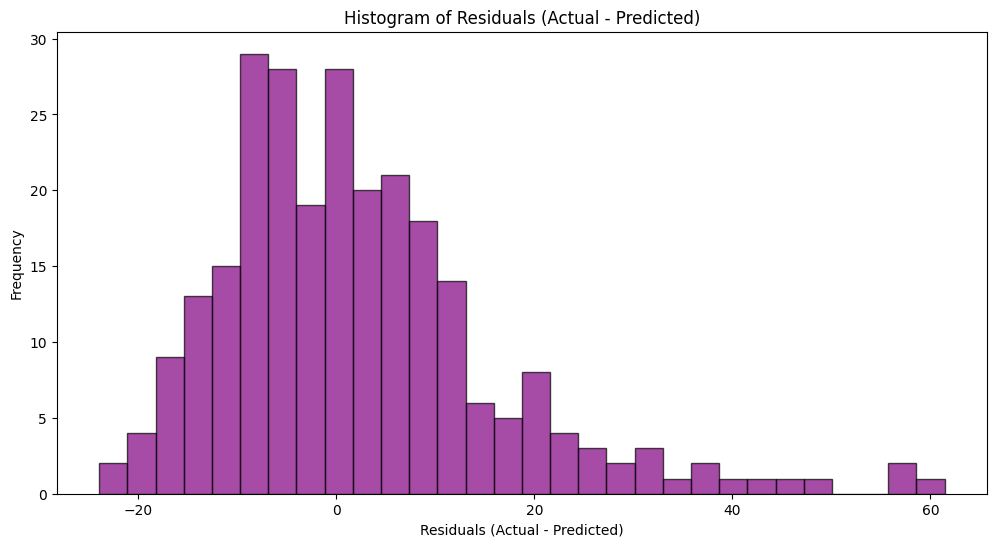

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Load the prepared dataset
data = pd.read_csv('ufc_fight_data_prepared_scaled.csv')

# Remove rows with any missing values
data_cleaned = data.dropna()

# Separate features and target
X = data_cleaned.drop(columns=['target'])
y = data_cleaned['target']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Plot histogram of residuals
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals (Actual - Predicted)')
plt.show()

In [25]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the prepared dataset
data = pd.read_csv('ufc_fight_data_prepared_scaled.csv')

# Remove rows with any missing values
data_cleaned = data.dropna()

# Separate features and target
X = data_cleaned.drop(columns=['target'])
y = data_cleaned['target']

# Split into training, validation, and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the input shape
input_shape = [X_train.shape[1]]

# Define the neural network model
model = tf.keras.Sequential([    
    tf.keras.layers.Dense(units=256, activation='relu', input_shape=input_shape),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.MAE)

# Train the model
losses = model.fit(X_train, y_train,
                   validation_data=(X_val, y_val),
                   batch_size=256,
                   epochs=500)


Epoch 1/500


/Users/tjkade/miniconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.1613 - val_loss: 14.8567
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8043 - val_loss: 11.8916
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.4501 - val_loss: 11.5871
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4889 - val_loss: 12.0053
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.5552 - val_loss: 11.8872
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2609 - val_loss: 11.6381
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2656 - val_loss: 11.4627
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0952 - val_loss: 11.4627
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0525 - val_loss: 11.7846
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1302 - val_loss: 11.7527
Epoch 11/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9455 - val_loss: 11.2948
Epoch 12/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9878 - val_loss: 11.25

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Absolute Error (MAE): 12.10958230563964
AVERAGE DIFF BETWEEN ACTUAL AND PREDICTED WINNER: 1.5836972361323478


/var/folders/gs/6h6mnw092pz8rlfn1m1rhk_80000gn/T/ipykernel_82021/476527956.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diffs.append(float(y_val.iloc[o] - predictions[o]))


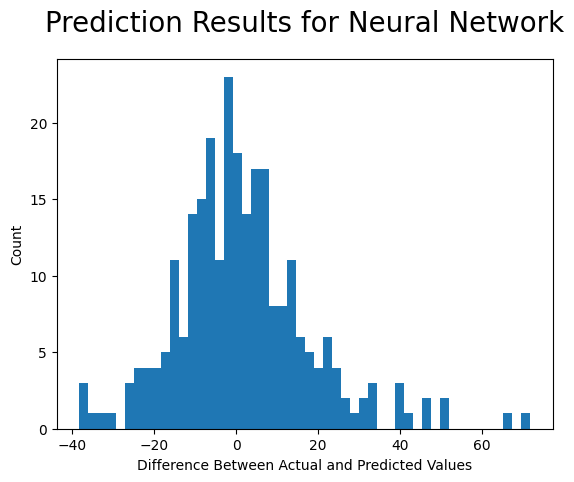

In [26]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Predict on the validation set
predictions = model.predict(X_val.iloc[:, :])

# Calculate MAE
mae = mean_absolute_error(y_val, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Assuming losses.history is correct
loss_df = pd.DataFrame(losses.history)

diffs = []

# Loop through the validation set and calculate the differences
for o in range(len(y_val)):
    # Use .iloc to access by index position
    if not np.isnan(y_val.iloc[o]) and not np.isnan(predictions[o]):
        diffs.append(float(y_val.iloc[o] - predictions[o]))

# Convert diffs to a NumPy array and check for any remaining NaN values
diffs = np.array(diffs)
diffs = diffs[~np.isnan(diffs)]  # Remove any remaining NaN values

# Plotting the histogram of the differences
plt.hist(diffs, bins=50)

# Print average difference
print('AVERAGE DIFF BETWEEN ACTUAL AND PREDICTED WINNER:', sum(diffs) / len(diffs))

plt.xlabel('Difference Between Actual and Predicted Values')
plt.ylabel('Count')
plt.title('Prediction Results for Neural Network', fontsize=20, pad=20)
# plt.savefig('../figures/NeuralNetHistogram.png', bbox_inches='tight')

plt.show()
